# Notes

- This Bayesian model assumes that people maintain the 6 grammars as possibilities in their heads and choose between them based on bayesian inference. Is this a plausible assumption to make in modeling JC? The theory (erosion of Neg1 + addition of initially emphatic Neg2) seems to describe a different mechanism?

In [11]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Constants

In [12]:
# Candidate utterance structures -> the 3 pure stages of JC:
# Preverbal, Discontinuous, Postverbal negation
CANDIDATES = ['NV', 'NVN', 'VN']  

# OT constraints (based on de Swart, 2009)
# A speaker's grammar (i.e., a language variant) is defined by
#   a hierarchy of universal constraints on the candidate utterances,
#   where constraints are ranked in order of importance.
# The constraints are:
# - Faith[Neg]: faithfulness to the negative polarity of the utterance -> requires the presence of a negator
# - *Neg: prefer utterances with fewer negators 
# - NegFirst: require (at least one) preverbal negator
# - NegLast: require (at least one) postverbal negator
CONSTRAINTS = ['Faith[Neg]', '*Neg', 'NegFirst', 'NegLast']

# Constraints assign violation scores to candidates based on their structure.
# -> Each candidate has a constraint violation profile - list of the violation scores for each constraint. 
    # Format: {candidate: violation scores for [Faith[Neg], *Neg, NegFirst, NegLast]}
VIOLATION_PROFILES = {
    'NV':   [0, 1, 0, 1],  # Preverbal negation: *Neg=1, violates NegLast
    'NVN':  [0, 2, 0, 0],  # Discontinuous negation: *Neg=2, no other violations
    'VN':   [0, 1, 1, 0],  # Postverbal negation: *Neg=1, violates NegFirst
}

# Constraint hierarchies (based on de Swart, 2009)
# Represent grammars (language variants) & correspond to Jespersen's Cycle stages.
# Each hierarchy is a list of the above constraints ordered by their importance
# (lower index = more important).
HIERARCHIES = {
    'H1': ['Faith[Neg]', '*Neg',     'NegFirst', 'NegLast'],  # Preverbal (Stage I)
    'H2': ['Faith[Neg]', 'NegFirst', '*Neg',     'NegLast'],  # Mixed: preverbal preferred (Stage II onset)
    'H3': ['Faith[Neg]', 'NegFirst', 'NegLast',  '*Neg'],     # Discontinuous (Stage II core)
    'H4': ['Faith[Neg]', 'NegLast',  'NegFirst', '*Neg'],     # Discontinuous (Stage II core)
    'H5': ['Faith[Neg]', 'NegLast',  '*Neg',     'NegFirst'], # Mixed: postverbal preferred (Stage III onset)
    'H6': ['Faith[Neg]', '*Neg',     'NegLast',  'NegFirst'], # Postverbal (Stage III)
}

## Likelihoods

In [13]:
### WEIGHTING SCHEMES FOR CONSTRAINTS IN HIERARCHIES ###

# Constraints are assigned weights based on their importance in a hierarchy
# (weights quantify the relative importance of each constraint in a hierarchy:
# higher weight = more important constraint).
# These are used to compute the likelihood of candidates given a hierarchy.
# The weighting scheme can be linear, logarithmic, or exponential.
def get_constraint_weights(hierarchy, type='linear'):
    """
    Get the weights for constraints in a given hierarchy.

    Args:
        hierarchy (str): The name of the hierarchy.
        type (str): The type of weighting scheme to use ('linear', 'logarithmic', or 'exponential').

    Returns:
        dict: A dictionary mapping constraints to their weights.
    """
    if type == 'linear':
        return {c: 4 - i for i, c in enumerate(HIERARCHIES[hierarchy])}
        # return {c: HIERARCHIES[hierarchy].index(c) + 1 for c in HIERARCHIES[hierarchy]}
    if type == 'logarithmic':
        return {c: 1 / (i + 1) for i, c in enumerate(HIERARCHIES[hierarchy])}
    elif type == 'exponential':
        return {c: 2 ** (4 - i) for i, c in enumerate(HIERARCHIES[hierarchy])}
    else:
        raise ValueError("Unknown weight type. Use 'linear', 'logarithmic', or 'exponential'.")

print(f"Weighting schemes for hierarchies:")
for name, hierarchy in HIERARCHIES.items():
    weights_log = get_constraint_weights(name, type='logarithmic')
    weights_lin = get_constraint_weights(name, type='linear')
    weights_exp = get_constraint_weights(name, type='exponential')
    print(f"{name}\tlin: {weights_lin}\n\tlog: {weights_log}\n\texp: {weights_exp}\n")
    break 


### LIKELIHOOD OF CANDIDATES GIVEN A HIERARCHY ###
# The likelihood of uttering a candidate given a hierarchy is calculated as
# the negative weighted sum of the candidate's constraint violations in that hierarchy.
def compute_likelihoods(hierarchy, weights_type='linear'):
    """Compute the likelihood of each candidate given a constraint hierarchy.
    Args:
        hierarchy (str): The name of the hierarchy to use.
        weights_type (str): The type of weighting scheme to use ('linear', 'logarithmic', or 'exponential').
    Returns:
        np.array: An array of likelihoods (probabilities) for each candidate in CANDIDATES.
    """
    # Assign weights to constraints based on the hierarchy and weighting type
    weights = get_constraint_weights(hierarchy, type=weights_type)
    
    violation_scores = []
    for cand in CANDIDATES:
        violations = VIOLATION_PROFILES[cand]
        # Calculate negative weighted sum of violations (harmony score)
        weighted_sum = -sum(weights[con] * v for con, v in zip(CONSTRAINTS, violations))  
        violation_scores.append(weighted_sum) 
    # Convert scores to probabilities using softmax normalization 
    exp_scores = np.exp(violation_scores)
    probs = exp_scores / exp_scores.sum()
    
    # Return a dictionary mapping candidates to their probabilities
    # return dict(zip(CANDIDATES, probs))
    return probs

LIKELIHOODS_DICT = {
    h: 
        {CANDIDATES[c]: 
            float(compute_likelihoods(h, weights_type='linear')[c])
            for c in range(len(CANDIDATES))} 
        for h in HIERARCHIES.keys()
    }
print("Likelihoods of candidates given hierarchies:")
print(LIKELIHOODS_DICT)

# Display the likelihoods of candidates for each hierarchy
likelihoods_df = pd.DataFrame(LIKELIHOODS_DICT)
display(likelihoods_df)

# print("Most likely candidate for each hierarchy:")
# # Display the most likely candidate for each hierarchy
# most_likely_candidates = {name: max(LIKELIHOODS_DICT[name], key=LIKELIHOODS_DICT[name].get) for name in LIKELIHOODS_DICT.keys()}
# for name, candidate in most_likely_candidates.items():
#     print(f"\t{name}: {candidate} (probability: {LIKELIHOODS_DICT[name][candidate]:.2f})")

Weighting schemes for hierarchies:
H1	lin: {'Faith[Neg]': 4, '*Neg': 3, 'NegFirst': 2, 'NegLast': 1}
	log: {'Faith[Neg]': 1.0, '*Neg': 0.5, 'NegFirst': 0.3333333333333333, 'NegLast': 0.25}
	exp: {'Faith[Neg]': 16, '*Neg': 8, 'NegFirst': 4, 'NegLast': 2}

Likelihoods of candidates given hierarchies:
{'H1': {'NV': 0.6652409557748219, 'NVN': 0.09003057317038046, 'VN': 0.24472847105479767}, 'H2': {'NV': 0.665240955774822, 'NVN': 0.24472847105479767, 'VN': 0.09003057317038048}, 'H3': {'NV': 0.24472847105479767, 'NVN': 0.6652409557748219, 'VN': 0.09003057317038045}, 'H4': {'NV': 0.09003057317038045, 'NVN': 0.6652409557748219, 'VN': 0.24472847105479767}, 'H5': {'NV': 0.09003057317038045, 'NVN': 0.2447284710547976, 'VN': 0.6652409557748219}, 'H6': {'NV': 0.24472847105479767, 'NVN': 0.09003057317038046, 'VN': 0.6652409557748219}}


,H1,H2,H3,H4,H5,H6
NV,0.665241,0.665241,0.244728,0.090031,0.090031,0.244728
NVN,0.090031,0.244728,0.665241,0.665241,0.244728,0.090031
VN,0.244728,0.090031,0.090031,0.244728,0.665241,0.665241


## Priors

In [14]:
UNIF_PRIOR = np.array([1/6] * 6)  # Uniform prior over the 6 hierarchies
PREVERBAL_PRIOR = np.array([1, 0, 0, 0, 0, 0], dtype=float)  # Pure preverbal negation (Stage I)
MIXED_PRIOR_PRE = np.array([0, 1, 0, 0, 0, 0], dtype=float)  # Mixed preverbal negation (Stage II onset)
DISCONTINUOUS_PRIOR = np.array([0, 0, 0.5, 0.5, 0, 0], dtype=float)  # Discontinuous negation (Stage II core)
MIXED_PRIOR_POST = np.array([0, 0, 0, 0, 1, 0], dtype=float)  # Mixed postverbal negation (Stage II onset)
POSTVERBAL_PRIOR = np.array([0, 0, 0, 0, 0, 1], dtype=float)  # Postverbal negation (Stage III)

# Model

In [15]:
class Agent:
    def __init__(self, prior, weights_type='linear'):
        """Initialize agent with specified prior or uniform distribution."""
        
        # Initialize agent's grammar hypotheses (the 6 constraint hierarchies)
        self.hypotheses = list(HIERARCHIES.keys())
        self.candidates = CANDIDATES  # Candidate utterances 
        
        # Initialize posterior probabilities based on specified prior (for the initial generation),
        self.posterior = prior.copy() 
        
        # Initialize weights type and compute likelihoods for each hypothesis
        self.weights_type = weights_type
        # Precompute likelihoods for each hypothesis using the specified weights type
        self.likelihoods = np.array([compute_likelihoods(h, weights_type=self.weights_type) for h in self.hypotheses]) 
        
        self.grammar_idx = None  # Current grammar (hierarchy) selected by the agent

    def generate_utterance(self, sampler=False):
        """Generate an utterance by sampling from candidates given agent's current grammar.
        Args:
            sampler (bool): Whether to use sampling (True) or maximization (False) for grammar selection.
        Returns:
            str: The generated utterance based on the selected grammar.
        """
        if self.grammar_idx is None:
            if sampler: 
                # Sampler strategy: sample hierarchy based on posterior probabilities
                self.grammar_idx = np.random.choice(
                    range(len(self.hypotheses)), 
                    p=self.posterior
                )
            else:
                # Maximizer strategy (MAP): choose hierarchy with highest posterior probability
                self.grammar_idx = np.argmax(self.posterior)
        
        # Sample utterance using the selected grammar
        likelihoods = self.likelihoods[self.grammar_idx]  # Use precomputed likelihoods
        # print(f"Likelihoods for hypothesis {self.hypotheses[self.grammar_idx]}: {likelihoods}")
        return np.random.choice(self.candidates, p=likelihoods)

    def learn(self, utterance):
        """Simulate learning using Bayesian inference to update the agent's 
        posterior probabilities based on the observed utterance.
        
        Args:
            utterance (str): The utterance observed by the agent.
        Returns:
            None: Updates the agent's posterior probabilities in place.
        """
        
        # Get the index of the utterance in candidates 
        utterance_idx = self.candidates.index(utterance)
        
        # Compute posterior in log-space to prevent underflow
        utterance_likelihoods = self.likelihoods.T[utterance_idx]
        # Retrieve likelihoods for the utterance across all hypotheses and convert to log-space
        log_likelihoods = np.log(utterance_likelihoods + 1e-9)  # Add small value to prevent log(0)
        # Compute unnormalized posterior probabilities in log-space
        log_priors = np.log(self.posterior + 1e-9)  # Add small value to prevent log(0)
        unnormalized_log_post = log_priors + log_likelihoods
        
        # Normalize posterior using log-sum-exp trick
        # max_log_post = np.max(unnormalized_log_post)
        # log_total = max_log_post + np.log(np.sum(np.exp(unnormalized_log_post - max_log_post)))
        log_total = np.log(np.sum(np.exp(unnormalized_log_post)))
        self.posterior = np.exp(unnormalized_log_post - log_total) 
        
        # Ensure the posterior sums to 1
        assert np.isclose(np.sum(self.posterior), 1.0), "Posterior probabilities do not sum to 1 after learning."


agent = Agent(prior=PREVERBAL_PRIOR, weights_type='linear')
print(f"Likelihoods:\n{agent.likelihoods}")
print("\n--- Generating utterance ---")
ut = agent.generate_utterance(sampler=True) 
print(f"Generated utterance: {ut}")
print("\n--- Learning ---")
print(f"Initial posterior probabilities:\n\t{agent.posterior}")
agent.learn('NVN')
print(f"Updated posterior probabilities:\n\t{agent.posterior}")

Likelihoods:
[[0.66524096 0.09003057 0.24472847]
 [0.66524096 0.24472847 0.09003057]
 [0.24472847 0.66524096 0.09003057]
 [0.09003057 0.66524096 0.24472847]
 [0.09003057 0.24472847 0.66524096]
 [0.24472847 0.09003057 0.66524096]]

--- Generating utterance ---
Generated utterance: NVN

--- Learning ---
Initial posterior probabilities:
	[1. 0. 0. 0. 0. 0.]
Updated posterior probabilities:
	[9.99999979e-01 2.71828175e-09 7.38905586e-09 7.38905586e-09
 2.71828175e-09 9.99999978e-10]


In [16]:
def simulate_jc_bayes(seed=42, generations=1000, agents_per_gen=5, 
                      learning_samples_per_agent=30, eval_samples_per_agent=100,
                      init_grammar='H1', weights_type='linear', sampler=False):
    """Simulate evolution of negation through iterated learning.
    Agents learn from adults in each generation and produce utterances for evaluation.
    
    Args:
        seed (int): Random seed for reproducibility.
        generations (int): Number of generations to simulate.
        agents_per_gen (int): Number of agents in each generation.
        learning_samples_per_agent (int): Number of samples each agent learns from adults.
        eval_samples_per_agent (int): Number of utterances each agent produces for evaluation.
        init_grammar (str): Initial grammar for the first generation ('H1', 'H2', etc.).
        sampler (bool): Whether to use sampling or maximization for utterance generation.
    Returns:
        list: History of proportions of negation types across generations."""
    
    # Set random seed for reproducibility
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    # Initialize first generation with specified grammar
    prev_gen = [Agent(
        prior=np.array([1.0 if h == init_grammar else 0.0 for h in HIERARCHIES.keys()]),
        weights_type=weights_type) 
        for _ in range(agents_per_gen)]
    history = []
    priors_hist = []

    # Run simulation across generations
    for gen in range(generations):
        if gen % 100 == 0:
            print(f"Generation {gen}/{generations}...")

        # Create new generation with uniform priors
        next_gen = []
        next_gen_prior = np.array([1/6] * 6)  # Uniform prior over the 6 hierarchies
        gen_priors = []

        for _ in range(agents_per_gen):
            learner = Agent(prior=next_gen_prior) 

            # Learning phase: each agent samples utterances from previous generation
            for _ in range(learning_samples_per_agent):
                # Choose a random adult agent to learn from
                adult_agent = random.choice(prev_gen)
                # Adult generates an utterance based on its grammar
                adult_utterance = adult_agent.generate_utterance(sampler)
                # New agent learns from the adult's utterance (i.e., updates its posterior)
                learner.learn(adult_utterance)
            next_gen.append(learner)
            # Store the posterior of the learner (i.e., the new agent)
            gen_priors.append(learner.posterior)
            
        # Store the grammars of the new generation
        priors_hist.append(gen_priors)

        # Evaluate production patterns of the new generation
        output = []
        for agent in next_gen:
            for _ in range(eval_samples_per_agent):
                output.append(agent.generate_utterance(sampler))
        
        # Calculate proportions of negation types
        counts = Counter(output)
        proportions = {c: counts.get(c, 0) / len(output) for c in CANDIDATES}
        history.append(proportions)
        
        # Next generation becomes adults
        prev_gen = next_gen

    # for gen in range(generations):
        # print(f"Generation {gen}")
        # for agent, posterior in enumerate(priors_hist[gen]):
            # Print the posterior probabilities of each agent in the generation
            # print(f"Agent {agent} posterior:\n\t{np.round(posterior, 4)}")

    return history

In [17]:
# Debugging with a small simulation

# sampler = False
# history = simulate_jc_bayes(seed=42, generations=2, agents_per_gen=5, 
#                             learning_samples_per_agent=30, eval_samples_per_agent=100,
#                             init_grammar='H1', weights_type='linear', sampler=sampler)
# display(pd.DataFrame(history).head())

In [18]:
def plot_history(history, model='MAP'):
    """Plot evolution of negation patterns over generations."""
    plt.figure(figsize=(12, 6))
    
    # Set x-axis as generation indices
    gens = list(range(len(history))) 
    
    # Plot proportions of each negation type over generations
    for cand in CANDIDATES:
        plt.plot(gens, [h.get(cand, 0) for h in history], label=cand)

    plt.xlabel("Generation")
    plt.ylabel("Proportion of Negation Types")
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.title(f"Evolution of Sentential Negation Types (Bayesian {model})")
    plt.legend()
    plt.grid(True)
    plt.show()

Generation 0/10000...
Generation 100/10000...
Generation 200/10000...
Generation 300/10000...
Generation 400/10000...
Generation 500/10000...
Generation 600/10000...
Generation 700/10000...
Generation 800/10000...
Generation 900/10000...
Generation 1000/10000...
Generation 1100/10000...
Generation 1200/10000...
Generation 1300/10000...
Generation 1400/10000...
Generation 1500/10000...
Generation 1600/10000...
Generation 1700/10000...
Generation 1800/10000...
Generation 1900/10000...
Generation 2000/10000...
Generation 2100/10000...
Generation 2200/10000...
Generation 2300/10000...
Generation 2400/10000...
Generation 2500/10000...
Generation 2600/10000...
Generation 2700/10000...
Generation 2800/10000...
Generation 2900/10000...
Generation 3000/10000...
Generation 3100/10000...
Generation 3200/10000...
Generation 3300/10000...
Generation 3400/10000...
Generation 3500/10000...
Generation 3600/10000...
Generation 3700/10000...
Generation 3800/10000...
Generation 3900/10000...
Generation 4

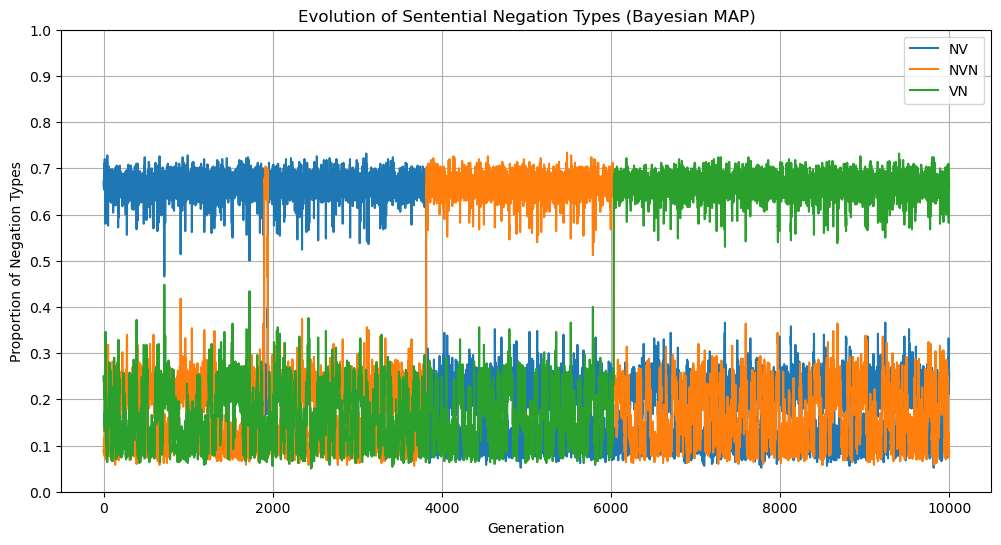

In [19]:
# Run using MAP strategy (sampler=False)
sampler = False
history = simulate_jc_bayes(seed=42, generations=10000, agents_per_gen=5, 
                            learning_samples_per_agent=30, eval_samples_per_agent=100,
                            init_grammar='H1', weights_type='linear', sampler=sampler)
plot_history(history, model='Sampler' if sampler else 'MAP')

Generation 0/1000...
Generation 100/1000...
Generation 200/1000...
Generation 300/1000...
Generation 400/1000...
Generation 500/1000...
Generation 600/1000...
Generation 700/1000...
Generation 800/1000...
Generation 900/1000...


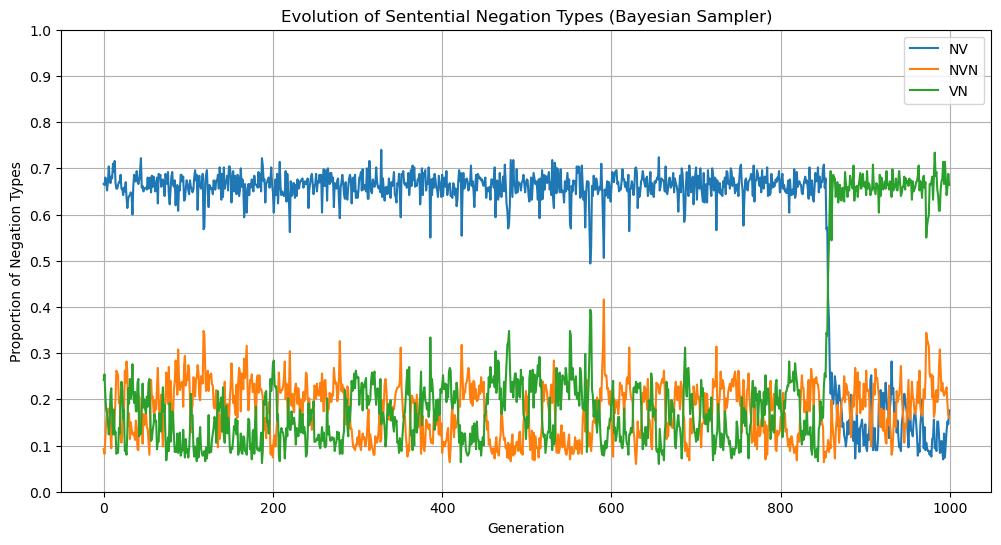

In [10]:
# With sampler strategy
sampler = True
history_sampler = simulate_jc_bayes(seed=42, generations=1000, agents_per_gen=5, 
                                    learning_samples_per_agent=30, eval_samples_per_agent=100, 
                                    init_grammar='H1', weights_type='linear', sampler=sampler)
plot_history(history_sampler, model='Sampler' if sampler else 'MAP')

# Multiple simulations

In [403]:
def run_multiple_simulations(n_runs=20, generations=1000):
    all_runs = []

    for seed in range(42, 42 + n_runs):
        print(f"Running simulation with seed {seed}...")
        run = simulate_jc_bayes(seed=seed, generations=generations, agents_per_gen=5, 
                            learning_samples_per_agent=30, eval_samples_per_agent=100,
                            init_grammar='H1', weights_type='linear', sampler=False)
        all_runs.append(run)

    return all_runs

In [404]:
def compute_statistics(all_runs):
    generations = len(all_runs[0])
    stats = {cand: {'mean': [], 'lower': [], 'upper': []} for cand in CANDIDATES}

    for gen in range(generations):
        for cand in CANDIDATES:
            vals = [run[gen].get(cand, 0) for run in all_runs]
            mean = np.mean(vals)
            stderr = np.std(vals) / np.sqrt(len(vals))
            ci = 1.96 * stderr
            stats[cand]['mean'].append(mean)
            stats[cand]['lower'].append(mean - ci)
            stats[cand]['upper'].append(mean + ci)

    return stats

In [ ]:
def plot_with_ci(stats):
    plt.figure(figsize=(12, 6))
    gens = list(range(len(stats[CANDIDATES[0]]['mean'])))

    for cand in CANDIDATES:
        mean = stats[cand]['mean']
        lower = stats[cand]['lower']
        upper = stats[cand]['upper']
        plt.plot(gens, mean, label=cand)
        plt.fill_between(gens, lower, upper, alpha=0.2)

    plt.xlabel("Generation")
    plt.ylabel("Proportion of Negation Types")
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.title("Evolution of Sentential Negation Types with Confidence Intervals")
    plt.legend()
    plt.grid(True)
    plt.show()

Running simulation with seed 42...
Generation 0/1000...
Generation 100/1000...
Generation 200/1000...
Generation 300/1000...
Generation 400/1000...
Generation 500/1000...
Generation 600/1000...
Generation 700/1000...
Generation 800/1000...
Generation 900/1000...
Running simulation with seed 43...
Generation 0/1000...
Generation 100/1000...
Generation 200/1000...
Generation 300/1000...
Generation 400/1000...
Generation 500/1000...
Generation 600/1000...
Generation 700/1000...
Generation 800/1000...
Generation 900/1000...
Running simulation with seed 44...
Generation 0/1000...
Generation 100/1000...
Generation 200/1000...
Generation 300/1000...
Generation 400/1000...
Generation 500/1000...
Generation 600/1000...
Generation 700/1000...
Generation 800/1000...
Generation 900/1000...
Running simulation with seed 45...
Generation 0/1000...
Generation 100/1000...
Generation 200/1000...
Generation 300/1000...
Generation 400/1000...
Generation 500/1000...
Generation 600/1000...
Generation 700/10

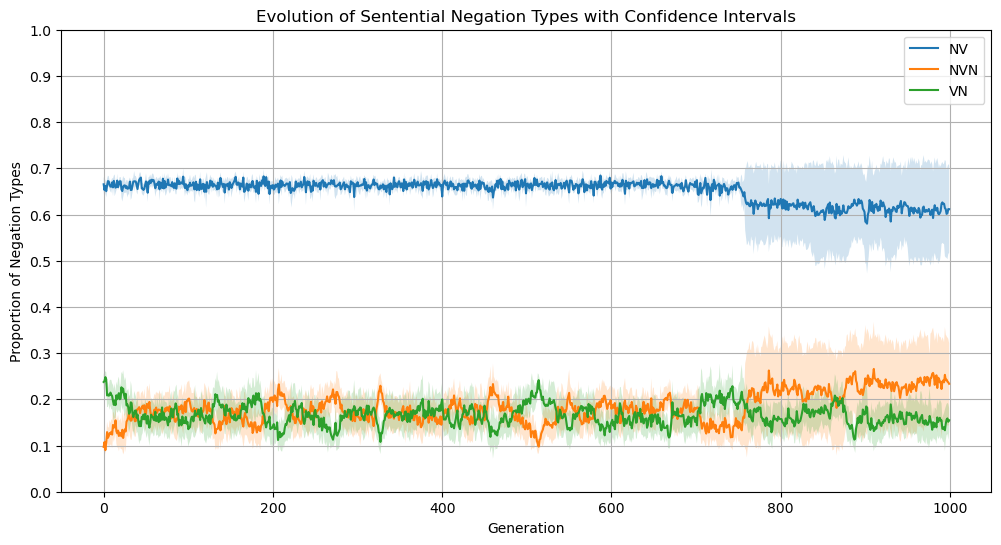

In [413]:
all_runs = run_multiple_simulations(n_runs=10, generations=1000)
stats = compute_statistics(all_runs)
plot_with_ci(stats)